In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import random
import scipy.stats as stats
import pylab as pl
import pmdarima
from pmdarima.arima import auto_arima, ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from tqdm import tqdm
"""from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2"""
warnings.simplefilter("ignore")

### Load Data set

In [21]:
from turtle import back


data = pd.read_excel('Updated_Data_0530.xlsx')
pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.set_index(pd.DatetimeIndex(data['Date']))
data = data[['선진국', '신흥국', '에너지외', '금', '달러', '대체', '안전채권','하이일드']]
data.columns = ["Advanced countries", " Emerging countries", "Non-Energy", "Gold", "Dollar", "Alternate", "Safety Bond", "Hyield"]

data = data.pct_change()[1:]

df = data[:2580]
backtest_df = data[2580:]

df.head()

# Store as .csv
df.to_csv('price_df.csv')
backtest_df.to_csv('backtest_df.csv')

### Create Portfolio

In [22]:
df = pd.read_csv('price_df.csv')
portfolio = list(df.columns.values[1:])
print(portfolio)

['Advanced countries', ' Emerging countries', 'Non-Energy', 'Gold', 'Dollar', 'Alternate', 'Safety Bond', 'Hyield']


### Prepare the Data

In [23]:
def rolling_corr(df, item1, item2):
    df_pair = pd.concat([df[item1], df[item2]], axis=1)
    df_pair.columns = [item1, item2]
    df_corr = df_pair[item1].rolling(window=100).corr(df_pair[item2])
    return df_corr

In [24]:
index_list = []
for _ in range(100):
    indices = []
    for k in range(_, 2420, 100):
        indices.append(k)
    index_list.append(indices)

data_matrix = []
count = 0
for i in range(8):
    for j in range(7-i):
        a = portfolio[i]
        b = portfolio[7-j]
        file_name = a + '_' + b

        corr_series = rolling_corr(df, a, b)[99:]
        corr_series.index = [i for i in range(len(corr_series))]
        for _ in range(100):
            corr_strided = list(corr_series[index_list[_]][:24]).copy()
            data_matrix.append(corr_strided)
            count+=1
            if count % 100 == 0 :
                print(str(count)+' items preprocessed')
                
data_matrix = np.transpose(data_matrix)
data_dictionary = {}
for i in range(len(data_matrix)):
    data_dictionary[str(i)] = data_matrix[i]
data_df = pd.DataFrame(data_dictionary)

data_df.to_csv('dataset.csv')


100 items preprocessed
200 items preprocessed
300 items preprocessed
400 items preprocessed
500 items preprocessed
600 items preprocessed
700 items preprocessed
800 items preprocessed
900 items preprocessed
1000 items preprocessed
1100 items preprocessed
1200 items preprocessed
1300 items preprocessed
1400 items preprocessed
1500 items preprocessed
1600 items preprocessed
1700 items preprocessed
1800 items preprocessed
1900 items preprocessed
2000 items preprocessed
2100 items preprocessed
2200 items preprocessed
2300 items preprocessed
2400 items preprocessed
2500 items preprocessed
2600 items preprocessed
2700 items preprocessed
2800 items preprocessed


### ARIMA_MODELING

In [25]:
df = pd.read_csv('dataset.csv')
df = df.loc[:, df.columns.str.contains('^Unnamed')]

num_list = []
for i in range(24):
    num_list.append(str(i))
data_df = data_df[num_list].copy()
data_df = np.transpose(data_df)
print(data_df.shape)

(24, 2800)


In [26]:
indices = [20*k for k in range(140)]
data_df = pd.DataFrame(data_df[indices])

train = []
dev = []
test1 = []
test2 = []

for i in range(data_df.shape[1]):
    tmp = data_df[20*i].copy()
    train.append(tmp[:21])
    dev.append(tmp[1:22])
    test1.append(tmp[2:23])
    test2.append(tmp[3:24])
    
train = pd.DataFrame(train)
dev = pd.DataFrame(dev)
test1 = pd.DataFrame(test1)
test2 = pd.DataFrame(test2)

train.to_csv('train_test_set/train.csv')
dev.to_csv('train_test_set/dev.csv')
test1.to_csv('train_test_set/test1.csv')
test2.to_csv('train_test_set/test2.csv')

11


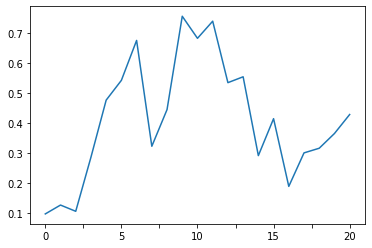

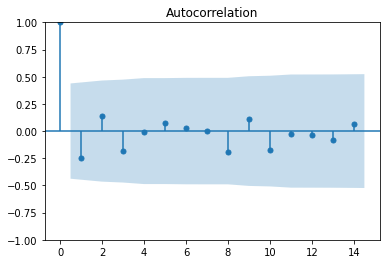

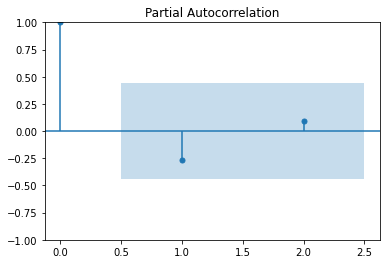

----------------------------------------------------


In [27]:
train = pd.read_csv('train_test_set/train.csv')
train = np.transpose(train.loc[:, ~train.columns.str.contains('^Unnamed')])
for _ in range(1):
    randint = random.randrange(0,140,1)
    print(randint)
    train[randint].plot()
    plt.show()
    plt.close()
    plot_acf(train[randint].diff()[1:])
    plt.show()
    plt.close()
    plot_pacf(train[randint].diff()[1:], lags=2)
    plt.show()
    plt.close()
    print('----------------------------------------------------')

In [28]:
train = pd.read_csv('train_test_set/train.csv')
dev = pd.read_csv('train_test_set/dev.csv')
test1 = pd.read_csv('train_test_set/test1.csv')
test2 = pd.read_csv('train_test_set/test2.csv')

train = np.transpose(train.loc[:,~train.columns.str.contains('^Unnamed')])
dev = np.transpose(dev.loc[:,~dev.columns.str.contains('^Unnamed')])
test1 = np.transpose(test1.loc[:,~test1.columns.str.contains('^Unnamed')])
test2 = np.transpose(test2.loc[:,~test2.columns.str.contains('^Unnamed')])

datasets = [train, dev, test1, test2]

In [29]:
model_110 = ARIMA(order=(1,1,0), suppress_warnings=True)
model_011 = ARIMA(order=(0,1,1), suppress_warnings=True)
model_111 = ARIMA(order=(1,1,1), suppress_warnings=True)
model_211 = ARIMA(order=(2,1,1), suppress_warnings=True)
model_210 = ARIMA(order=(2,1,0), suppress_warnings=True)

train_X = []; train_Y = []
dev_X = []; dev_Y = []
test1_X = []; test1_Y = []
test2_X = []; test2_Y = []

flag = 0

for i in tqdm(range(140)):
    tmp = []
    c=0
    for s in datasets :
        c+=1
        try:
            model1 = model_110.fit(s[i])
            model = model1
            
            try:
                model2 = model_011.fit(s[i])
                
                if model.aic() <= model2.aic() :
                    pass
                else :
                    model = model2
                    
                try :
                    model3 = model_111.fit(s[i])
                    if model.aic() <= model3.aic() :
                        pass
                    else :
                        model = model3
                except :
                    try:
                        model4 = model_211.fit(s[i])
                        
                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            model = model4
                    except:
                        try:
                            model5 = model_210.fit(s[i])
                            
                            if model.aic() <= model5.aic():
                                pass
                            else :
                                model = model5
                        except :
                            pass
                    
            except:
                try:
                    model3 = model_111.fit(s[i])

                    if model.aic() <= model3.aic() :
                        pass
                    else :
                        model = model3
                except :
                    try:
                        model4 = model_211.fit(s[i])
                        
                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            model = model4
                    except:
                        try:
                            model5 = model_210.fit(s[i])
                            
                            if model.aic() <= model5.aic():
                                pass
                            else :
                                model = model5
                        except :
                            pass
                
        except:
            try:
                model2 = model_011.fit(s[i])
                model = model2
            
                try :
                    model3 = model_111.fit(s[i])
                    
                    if model.aic() <= model3.aic():
                        pass
                    else:
                        model = model3
                except :
                    try:
                        model4 = model_211.fit(s[i])
                        
                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            model = model4
                    except:
                        try:
                            model5 = model_210.fit(s[i])
                            
                            if model.aic() <= model5.aic():
                                pass
                            else :
                                model = model5
                        except :
                            pass
            
            except :
                try:
                    model3 = model_111.fit(s[i])
                    model = model3
                except :
                    try:
                        model4 = model_211.fit(s[i])
                        
                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            model = model4
                    except:
                        try:
                            model5 = model_210.fit(s[i])
                            
                            if model.aic() <= model5.aic():
                                pass
                            else :
                                model = model5
                        except :
                            flag = 1
                            print(str(c) + " FATAL ERROR")
                            break
        
        predictions = list(model.predict_in_sample())
        #pad the first time step of predictions with the average of the prediction values
        #so as to match the length of the s[i] data
        
        residual = pd.Series(np.array(s[i]) - np.array(predictions))
        tmp.append(np.array(residual))
        
                    
    if flag == 1:
        break
    train_X.append(tmp[0][:20])
    train_Y.append(tmp[0][20])
    dev_X.append(tmp[1][:20])
    dev_Y.append(tmp[1][20])
    test1_X.append(tmp[2][:20])
    test1_Y.append(tmp[2][20])
    test2_X.append(tmp[3][:20])
    test2_Y.append(tmp[3][20])

100%|██████████| 140/140 [00:50<00:00,  2.77it/s]


In [30]:
pd.DataFrame(train_X).to_csv('after_arima/train_X.csv')
pd.DataFrame(dev_X).to_csv('after_arima/dev_X.csv')
pd.DataFrame(test1_X).to_csv('after_arima/test1_X.csv')
pd.DataFrame(test2_X).to_csv('after_arima/test2_X.csv')
pd.DataFrame(train_Y).to_csv('after_arima/train_Y.csv')
pd.DataFrame(dev_Y).to_csv('after_arima/dev_Y.csv')
pd.DataFrame(test1_Y).to_csv('after_arima/test1_Y.csv')
pd.DataFrame(test2_Y).to_csv('after_arima/test2_Y.csv')

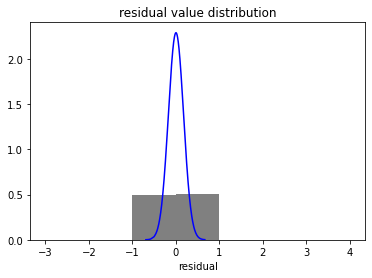

0.0 % of the data is out of bound [-2,2]
0.0 % of the data is out of bound [-1,1]


In [31]:
train = pd.read_csv('after_arima/train_X.csv')
train = np.transpose(train.loc[:,~train.columns.str.contains('^Unnamed')])
train_melt = sorted(np.array(train.melt()['value']))
fit = stats.norm.pdf(train_melt, np.mean(train_melt), np.std(train_melt))
pl.hist(train_melt, color='grey', bins=[-3,-2,-1,0,1,2,3,4], density=True)
pl.plot(train_melt,fit,color='blue')
pl.title('residual value distribution')
pl.xlabel('residual')
pl.show()
pl.close()

X = [x for x in train_melt if x>2]
Y = [y for y in train_melt if y<-2]
out_of_bound = X + Y
print(str(len(out_of_bound)/11175) +' % of the data is out of bound [-2,2]')

X = [x for x in train_melt if x>1]
Y = [y for y in train_melt if y<-1]
out_of_bound = X + Y
print(str(len(out_of_bound)/11175) +' % of the data is out of bound [-1,1]')

### MISCELLANEOUS

In [32]:
stat = pd.DataFrame()
for i in range(140):
    df = train[i].describe()
    stat[i] = df

stat

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.029125,0.020261,0.023727,0.021942,0.031492,0.010821,0.003712,0.006359,0.015314,0.018651,...,-0.033299,-0.040430,-0.035709,-0.036541,-0.025569,0.001220,0.010215,0.006356,0.009682,0.012224
std,0.186801,0.233768,0.236081,0.247794,0.215610,0.218560,0.226609,0.227446,0.240183,0.235035,...,0.156889,0.211704,0.230185,0.218869,0.181179,0.197557,0.214446,0.193127,0.187677,0.177733
min,-0.282661,-0.435023,-0.369347,-0.312491,-0.295062,-0.345433,-0.361007,-0.315779,-0.362692,-0.459840,...,-0.439898,-0.595747,-0.579355,-0.495471,-0.498692,-0.354719,-0.304824,-0.282684,-0.284382,-0.319892
25%,-0.095949,-0.157359,-0.134466,-0.177713,-0.128308,-0.168474,-0.169771,-0.175768,-0.155045,-0.162246,...,-0.105764,-0.180410,-0.132071,-0.163208,-0.110024,-0.110440,-0.143514,-0.113935,-0.109631,-0.074708
50%,0.037710,0.023433,-0.026899,-0.015898,0.033868,0.024162,-0.044317,-0.011837,0.013867,0.014202,...,-0.043028,-0.048821,-0.039983,-0.049656,-0.051741,-0.020663,0.023759,0.012531,0.049992,0.043549
75%,0.157565,0.184567,0.212928,0.207324,0.155523,0.150045,0.120955,0.109225,0.129987,0.216623,...,0.048300,0.097652,0.080456,0.075289,0.105782,0.114819,0.153199,0.076012,0.110707,0.105708
max,0.398493,0.417840,0.437230,0.574387,0.611194,0.528029,0.491382,0.513282,0.534310,0.441445,...,0.347956,0.385859,0.497065,0.508000,0.261960,0.325453,0.372769,0.369054,0.327928,0.344337


In [33]:
mean = sorted(np.array(stat.iloc[1,:].copy()))
stdev = sorted(np.array(stat.iloc[2,:].copy()))
fit1 = stats.norm.pdf(mean, np.mean(mean), np.std(mean))
fit2 = stats.norm.pdf(stdev, np.mean(stdev), np.std(stdev))

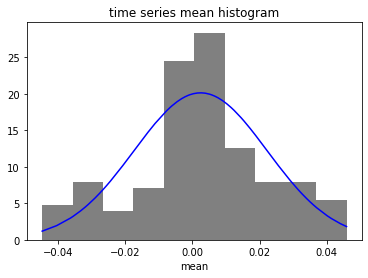

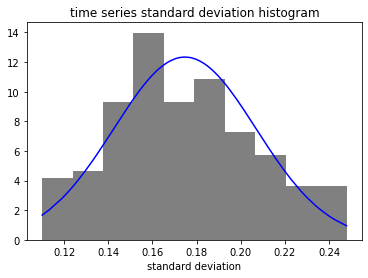

In [34]:
pl.plot(mean,fit1,color='blue')
pl.hist(mean,density=True,color='grey')
pl.title('time series mean histogram')
pl.xlabel('mean')
pl.show()
pl.close()
pl.plot(stdev,fit2,color='blue')
pl.hist(stdev,density=True,color='grey')
pl.title('time series standard deviation histogram')
pl.xlabel('standard deviation')
pl.show()
pl.close()